# Foreign Exchange Forecasting

## Import Library

In [59]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, pytz

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Constants

In [60]:
# Load data from Google Spreadsheet
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = 'USD/IDR'

## Pre-Processing

In [61]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
data = pd.read_csv(url)

# Drop unused columns
data = data.drop('Unnamed: 2', axis=1)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1247 non-null   datetime64[ns]
 1   Close   1247 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.6 KB


In [62]:
data.head()

,Date,Close
0,2020-01-01 23:58:00,13689.23
1,2020-01-02 23:58:00,13884.79
2,2020-01-03 23:58:00,13935.46
3,2020-01-04 23:58:00,13935.46
4,2020-01-05 23:58:00,13934.32


In [63]:
data = data.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
data = data.set_index('Date')

In [64]:
split_date = '1-Jan-2023'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [65]:
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

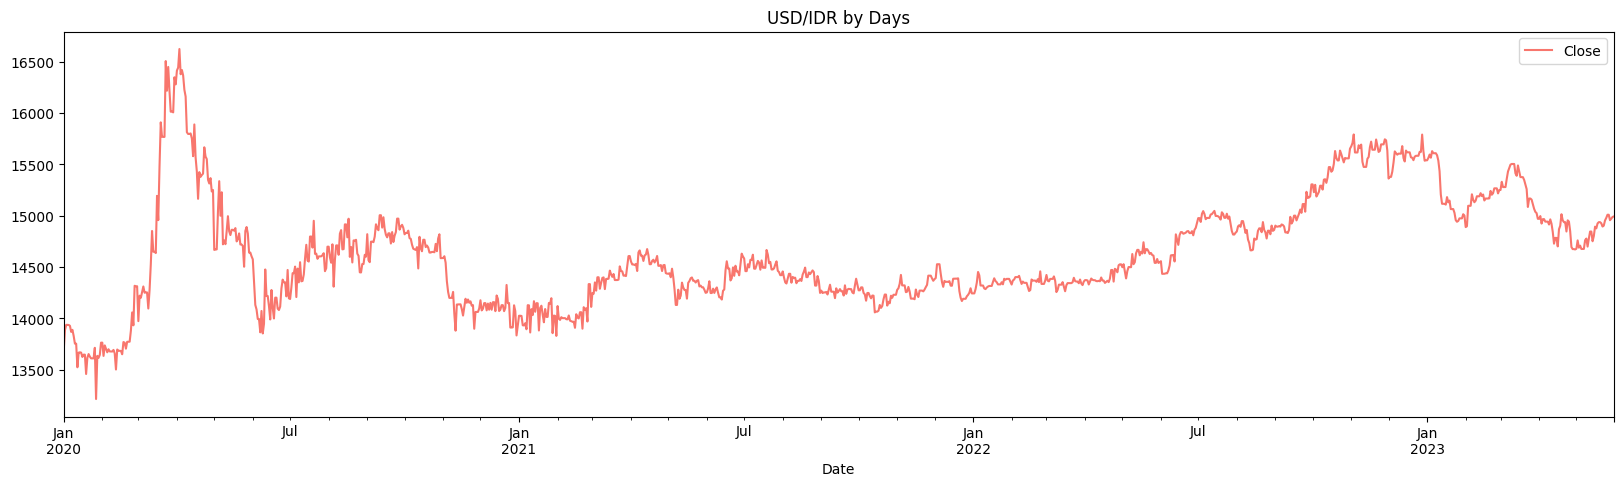

In [66]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(20,5), color=color_pal[0], title='USD/IDR by Days')

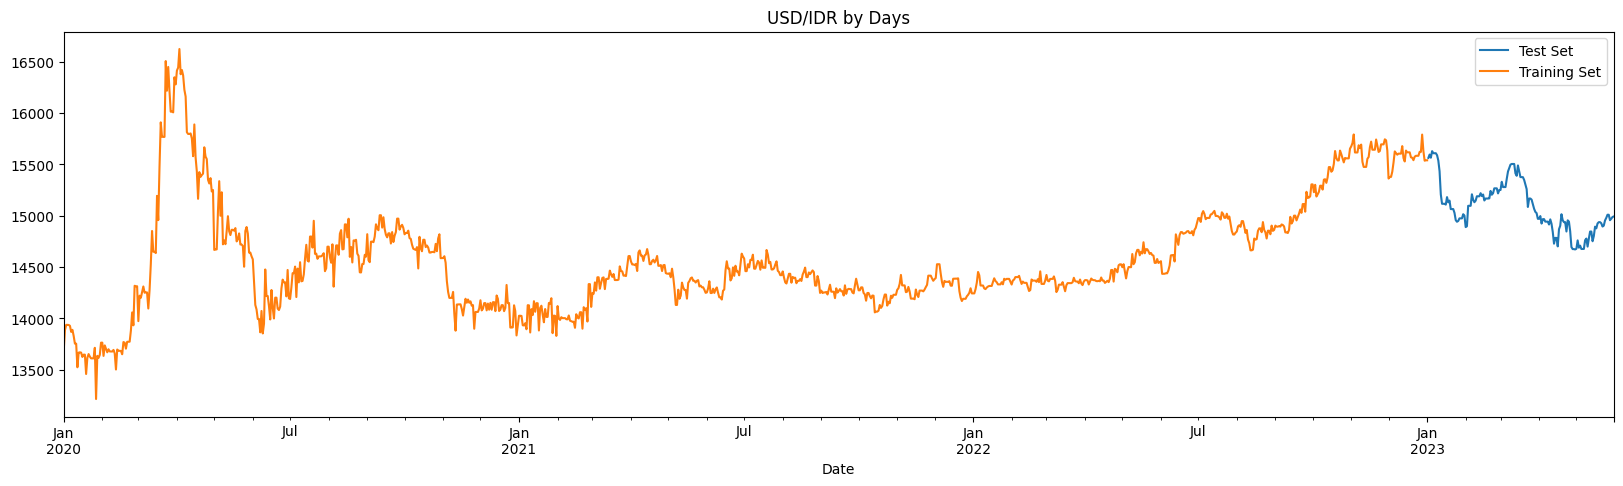

In [67]:
_ = data_test \
    .rename(columns={'Close': 'Test Set'}) \
    .join(data_train.rename(columns={'Close': 'Training Set'}), how='outer') \
    .plot(figsize=(20,5), title='USD/IDR by Days', style='')

## Model Build

In [68]:

model = Sequential([
    # LSTM(50, input_shape=(1,1)),
    # Dense(1)
    LSTM(128, input_shape=(1, 1), return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(1),
], name='LSTM')

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])

model.summary()

2023-06-08 21:58:37.440003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 21:58:37.441280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 21:58:37.442272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 128)            66560     
                                                                 
 lstm_11 (LSTM)              (None, 1, 64)             49408     
                                                                 
 lstm_12 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


2023-06-08 21:58:37.718691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 21:58:37.720654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 21:58:37.721731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [69]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    validation_split=0.1)

Epoch 1/50


2023-06-08 21:58:38.004492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 21:58:38.006002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 21:58:38.007283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/31 [===========================>..] - ETA: 0s - loss: 0.1040 - mae: 0.2933

2023-06-08 21:58:41.501243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 21:58:41.502634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 21:58:41.503628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 4s 37ms/step - loss: 0.0994 - mae: 0.2841 - val_loss: 0.1433 - val_mae: 0.3747
Epoch 2/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0121 - mae: 0.0814 - val_loss: 0.0536 - val_mae: 0.2268
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0075 - mae: 0.0625 - val_loss: 0.0268 - val_mae: 0.1593
Epoch 4/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0049 - mae: 0.0516 - val_loss: 0.0119 - val_mae: 0.1056
Epoch 5/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0026 - mae: 0.0370 - val_loss: 0.0040 - val_mae: 0.0602
Epoch 6/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0015 - mae: 0.0268 - val_loss: 7.4082e-04 - val_mae: 0.0219
Epoch 7/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0014 - val_mae: 0.0328
Epoch 8/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0013 - mae: 0.0

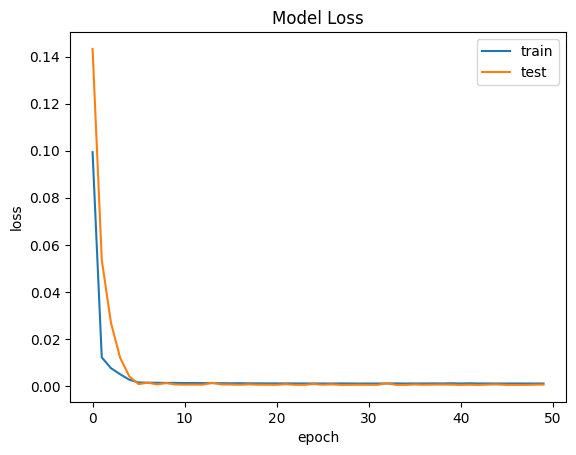

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Predictions

In [71]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_USD_price = model.predict(inputs)
predicted_USD_price = sc.inverse_transform(predicted_USD_price)

2023-06-08 21:59:03.464722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 21:59:03.466546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 21:59:03.467903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 1s 6ms/step


In [72]:
data_test['Close_Price_Prediction'] = predicted_USD_price
data_all = pd.concat([data_test, data_train], sort=False)

In [73]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Close_Price_Prediction': 'lstm'})
final_data = final_data[['Date','Close','lstm']]

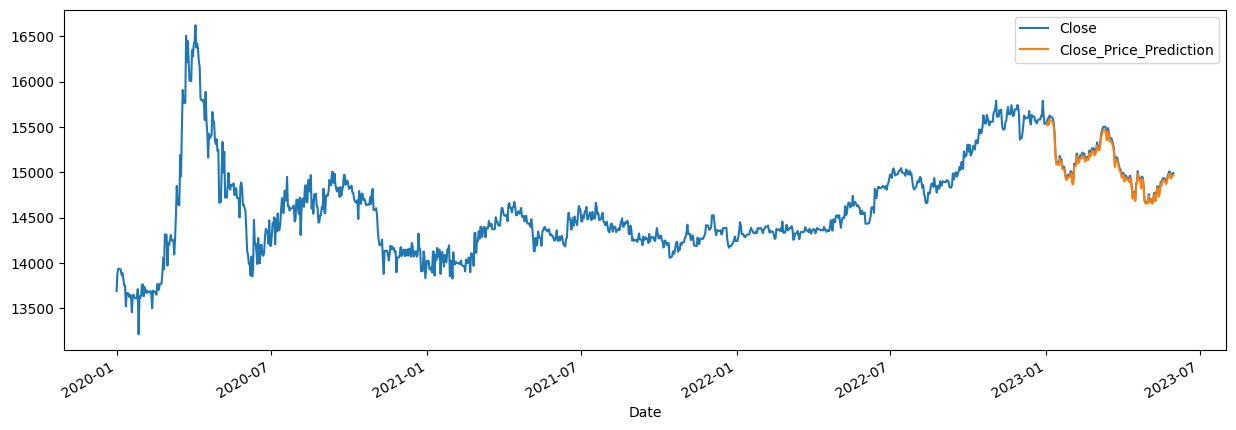

In [74]:
_ = data_all[['Close','Close_Price_Prediction']].plot(figsize=(15, 5))

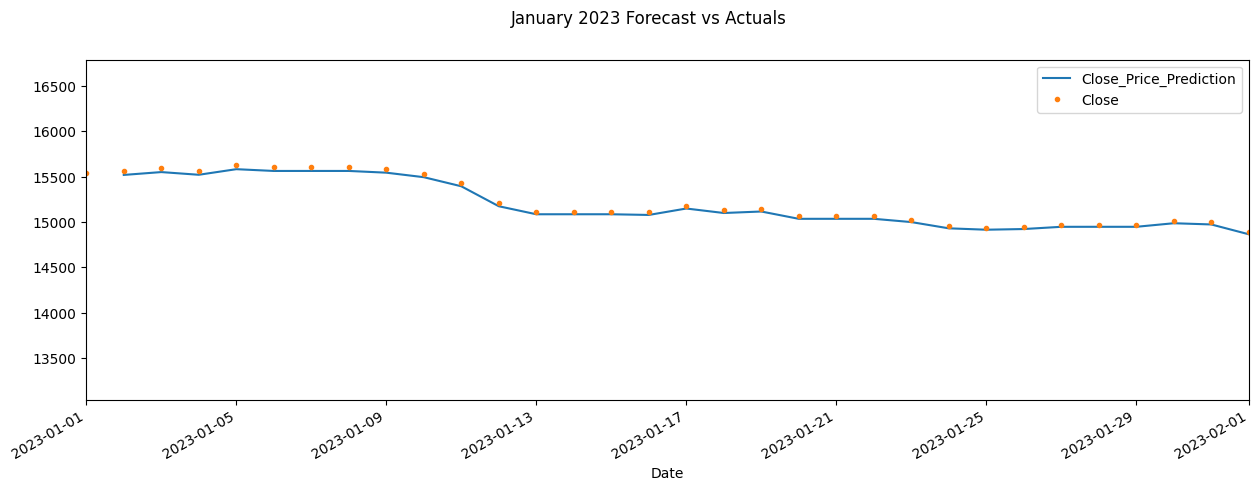

In [75]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Close_Price_Prediction','Close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2023', upper='02-01-2023')
plot = plt.suptitle('January 2023 Forecast vs Actuals')

In [76]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Squared Error for prediction :", mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Root Mean Squared Error for prediction :", rmse)
    
matrices(data_test['Close'], data_test['Close_Price_Prediction'])

Mean Squared Error for prediction : 781.9312890144315
Mean Absolute Error for prediction : 27.123493489583282
Root Mean Squared Error for prediction : 27.963034331317328
